## Notebook used for plotting the results in the tabular case.
Make sure to have collected the data first by executing the `run_experiments_tabular.ipynb` notebook.

In [ ]:
import numpy as np
import lzma
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict
from tabular.agents.mr_nas import MRNaSParameters

from tabular.agents.mr_psrl import MRPSRLparameters
from tabular.simulation_parameters import SimulationParameters
from tabular.utils.utils import Results
from typing import List, NamedTuple, Sequence
from tabular.config import CONFIG
from scipy.stats import t as tstudent
from scipy.stats import bootstrap
from matplotlib.ticker import PercentFormatter

class DataResults(NamedTuple):
    simulation_parameters: SimulationParameters
    agent_type: str
    data: Sequence[Sequence[Results]]

def seq_to_numpy(data: Sequence[Sequence[Results]], key: str):
    seeds = len(data)
    len_seq = len(data[0])
    seq = np.array(
            [np.vstack(
                [data[x][y].__getattribute__(key) for x in range(seeds)]
                )
            for y in range(len_seq)]
        )
    return seq

In [10]:
TITLE_SIZE = 16
LEGEND_SIZE = 13
TICK_SIZE = 13
AXIS_TITLE = 16
AXIS_LABEL = 13
FONT_SIZE = 13


rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": r'\usepackage{amsmath}\usepackage{mathtools} \usepackage{amssymb}'
}
plt.rcParams.update(rc_parameters)
plt.rcParams["text.latex.preamble"].join([
        r"\usepackage{amsmath}",              
        r"\usepackage{mathtools}",
        r"\usepackage{amssymb}"
])

# colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
colors = {
    'ID3AL': '#f8766d',
    'MR-NaS': '#00bfc4',
    'RF-UCRL': 'mediumorchid',
    'MR-PSRL': '#3B3B3B'
}
ordered_agents = ['MR-NaS','RF-UCRL', 'ID3AL', 'MR-PSRL']
ordered_envs = ['Riverswim', 'ForkedRiverswim', 'DoubleChain', 'NArms']
sns.set_style("darkgrid", rc=rc_parameters)

In [11]:

class RenamingUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'tabular.agents.rf_bpi':
            module = 'tabular.agents.mr_nas'
        if module == 'tabular.agents.rf_psrl':
            module = 'tabular.agents.mr_psrl'
        if name == 'RFBPIParameters':
            return MRNaSParameters
        if name == 'RFPSRLparameters':
            return MRPSRLparameters
        
        return super().find_class(module, name)
    
cfg = CONFIG
results: Dict[str, Dict[str, DataResults]] = {}
for env_params, agents in cfg.envs:
    path = f'./tabular/data/{env_params.env_type.value}/{env_params.horizon}/'
    results[env_params.env_type.value] = {}
    for agent in agents:
        with lzma.open(f'{path}/{agent.type}.pkl.lzma', 'rb') as f:
            results[env_params.env_type.value][agent.type] = RenamingUnpickler(f).load()


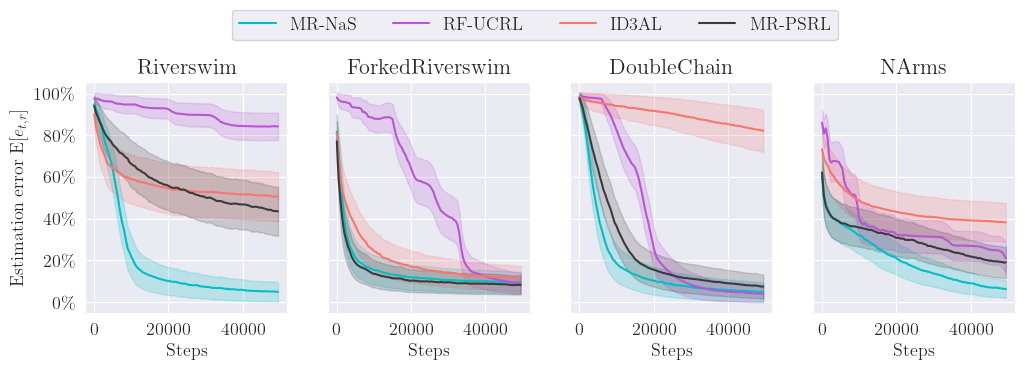

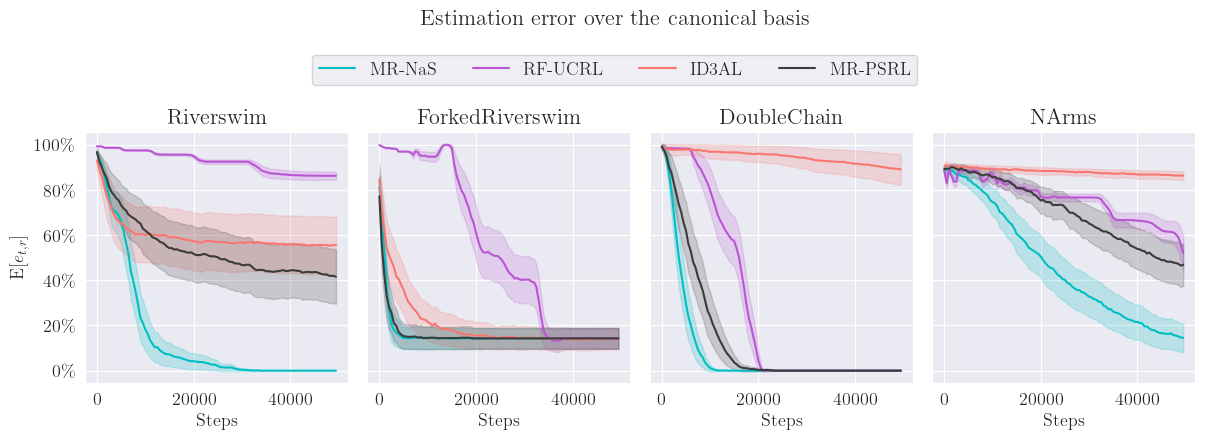

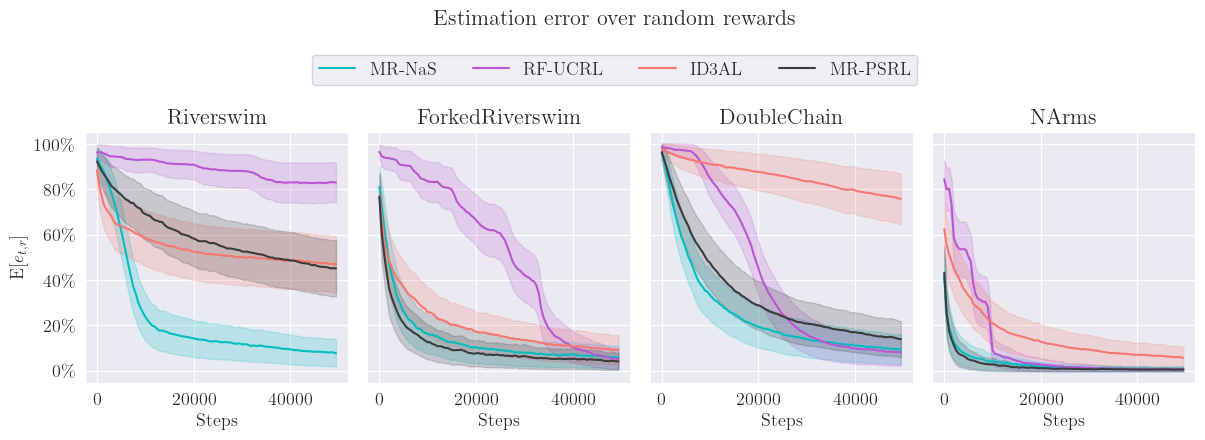

In [112]:
seeds = cfg.sim_parameters.num_sims
num_rewards = cfg.sim_parameters.num_rewards

c = 0.95
alpha = c + (1-c)/2
c = tstudent.ppf(alpha, seeds)

for plot_id in range(3):
    size_y = 3 if plot_id == 0 else 4
    fig, ax = plt.subplots(nrows=1, ncols=len(results.keys()), figsize=(12,size_y), sharey=True)
    ax_id = 0

    for env in ordered_envs:
        agents = results[env]
        
        for agent in ordered_agents:
            agent_data = agents[agent]
            horizon = agent_data.simulation_parameters.env_parameters.horizon
            freq_eval = agent_data.simulation_parameters.sim_parameters.freq_eval
            xticks = np.arange(len(agent_data.data[0])) * freq_eval

            seq = seq_to_numpy(agent_data.data, 'pi_res')
            if plot_id == 1:
                seq = seq[...,:-num_rewards]
            elif plot_id == 2:
                seq = seq[..., num_rewards:]
    
            mu = seq.mean(-1).mean(-1)
            std = seq.mean(-1).std(-1,ddof=1) + seq.std(-1,ddof=1).mean(-1)
            ce = c * std / np.sqrt(seeds)
            ax[ax_id].plot(xticks, mu, colors[agent], label=agent)
            ax[ax_id].fill_between(xticks, mu-ce, mu+ce, alpha=0.2, color=colors[agent])
            ax[ax_id].set_xlabel('Steps')
            ax[ax_id].yaxis.set_major_formatter(PercentFormatter(1.0))
        ax[ax_id].set_title(env)
        ax_id += 1
    handles, labels = ax[0].get_legend_handles_labels()
    
    if plot_id == 0: 
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True, ncols=len(agents))
        ax[0].set_ylabel(r'Estimation error $\mathrm{E}[e_{t,r}]$')
        plt.savefig('tabular/figures/estimation_error.pdf', bbox_inches='tight')
    elif plot_id == 1:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), frameon=True, ncols=len(agents))
        plt.suptitle('Estimation error over the canonical basis',y=1.1)
        fig.tight_layout()
        ax[0].set_ylabel(r'$\mathrm{E}[e_{t,r}]$')
        plt.savefig('tabular/figures/estimation_error_canonical_base.pdf', bbox_inches='tight')
    elif plot_id == 2:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), frameon=True, ncols=len(agents))
        plt.suptitle('Estimation error over random rewards',y=1.1)
        fig.tight_layout()
        ax[0].set_ylabel(r'$\mathrm{E}[e_{t,r}]$')
        plt.savefig('tabular/figures/estimation_error_random_rewards.pdf', bbox_inches='tight')

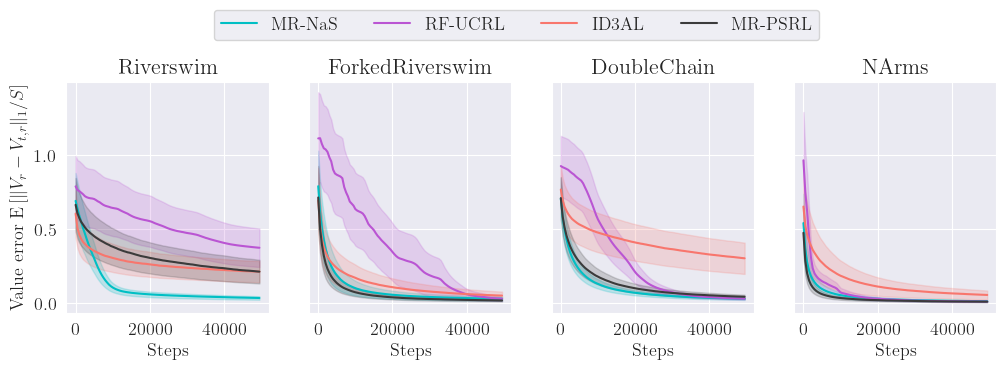

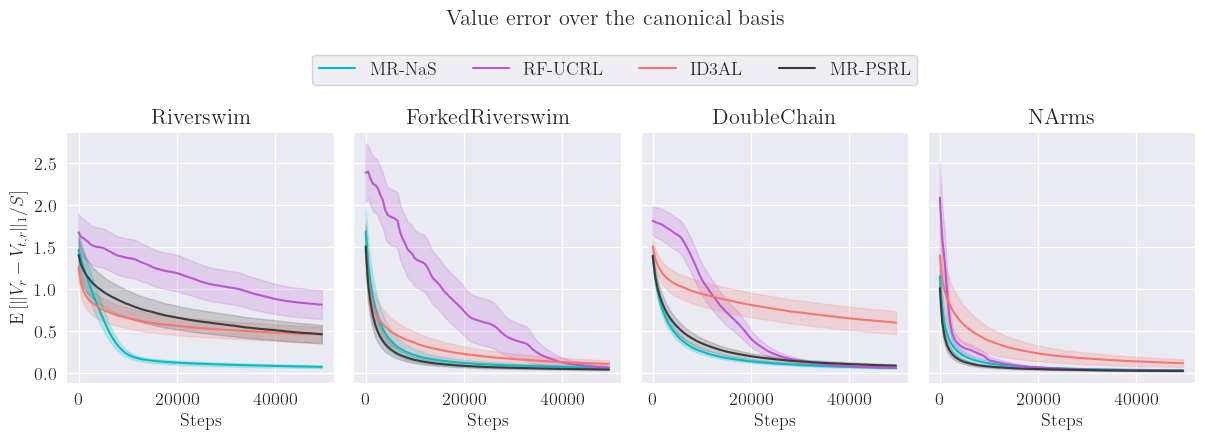

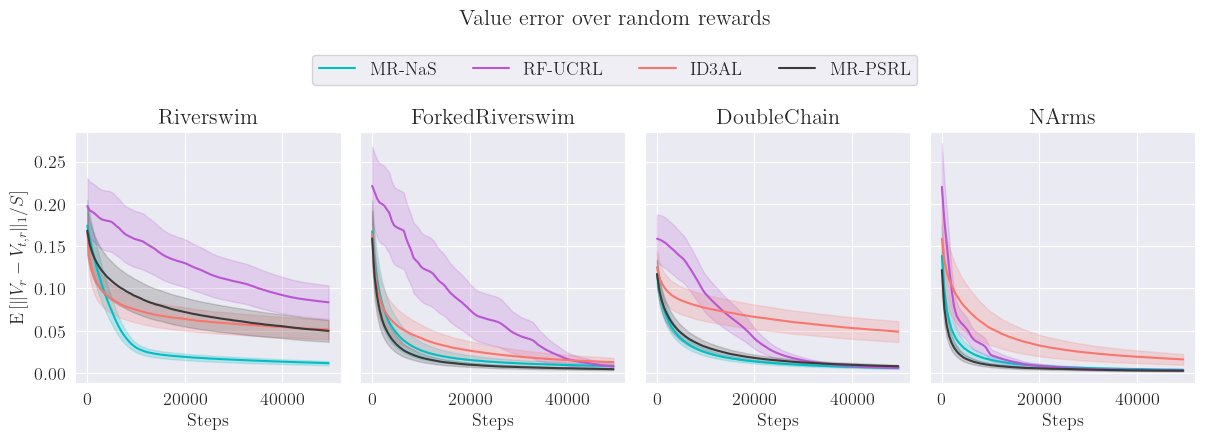

In [110]:
seeds = cfg.sim_parameters.num_sims
num_rewards = cfg.sim_parameters.num_rewards

c = 0.95
alpha = c + (1-c)/2
c = tstudent.ppf(alpha, seeds)

for plot_id in range(3):
    size_y = 3 if plot_id == 0 else 4
    fig, ax = plt.subplots(nrows=1, ncols=len(results.keys()), figsize=(12,size_y), sharey=True)
    ax_id = 0

    for env in ordered_envs:
        agents = results[env]
        
        for agent in ordered_agents:
            agent_data = agents[agent]
            horizon = agent_data.simulation_parameters.env_parameters.horizon
            freq_eval = agent_data.simulation_parameters.sim_parameters.freq_eval
            xticks = np.arange(len(agent_data.data[0])) * freq_eval

            seq = seq_to_numpy(agent_data.data, 'V_res')
            if plot_id == 1:
                seq = seq[...,:-num_rewards]
            elif plot_id == 2:
                seq = seq[..., num_rewards:]
    
            n = seq.shape[0]
            mu = seq.mean(-1).mean(-1)

            
            std = seq.mean(-1).std(-1,ddof=1) + seq.std(-1,ddof=1).mean(-1)
            ce = c * std / np.sqrt(seeds)
            ax[ax_id].plot(xticks, mu, colors[agent], label=agent)
            ax[ax_id].fill_between(xticks, mu-ce, mu+ce, alpha=0.2, color=colors[agent])
            ax[ax_id].set_xlabel('Steps')

        ax[ax_id].set_title(env)
        ax_id += 1
    handles, labels = ax[0].get_legend_handles_labels()
    
    
    if plot_id == 0: 
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True, ncols=len(agents))
        ax[0].set_ylabel(r'Value error $\mathrm{E}\left[\|V_r - V_{t,r}\|_1 /S\right]$')
        plt.savefig('tabular/figures/value_error.pdf', bbox_inches='tight')
    elif plot_id == 1:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), frameon=True, ncols=len(agents))
        plt.suptitle('Value error over the canonical basis', y=1.1)
        fig.tight_layout()
        ax[0].set_ylabel(r'$\mathrm{E}\left[\|V_r - V_{t,r}\|_1 /S\right]$')
        plt.savefig('tabular/figures/value_error_canonical_base.pdf', bbox_inches='tight')
    elif plot_id == 2:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), frameon=True, ncols=len(agents))
        plt.suptitle('Value error over random rewards', y=1.1)
        fig.tight_layout()
        ax[0].set_ylabel(r'$\mathrm{E}\left[\|V_r - V_{t,r}\|_1/S \right]$')
        plt.savefig('tabular/figures/value_error_random_rewards.pdf', bbox_inches='tight')

In [ ]:
seeds = cfg.sim_parameters.num_sims
num_rewards = cfg.sim_parameters.num_rewards


fig, ax = plt.subplots(nrows=1, ncols=len(results.keys()), figsize=(12,3))
ax_id = 0

for env in ordered_envs:
    agents = results[env]
    
    for agent in ordered_agents:
        agent_data = agents[agent]
        horizon = agent_data.simulation_parameters.env_parameters.horizon
        freq_eval = agent_data.simulation_parameters.sim_parameters.freq_eval
        xticks = np.arange(len(agent_data.data[0])) * freq_eval

        seq = seq_to_numpy(agent_data.data, 'last_visit')
        seq = seq.max(-1)-seq.min(-1)

        conf = bootstrap((seq,), np.mean, axis=1).confidence_interval


        mu = seq.mean(-1)
        ax[ax_id].plot(xticks, mu, colors[agent], label=agent)
        ax[ax_id].fill_between(xticks, conf.low, conf.high, alpha=0.2, color=colors[agent])
        ax[ax_id].set_xlabel('Steps')
        #ax[ax_id].yaxis.set_major_formatter(PercentFormatter(1.0))

    ax[ax_id].set_title(env)
    ax[ax_id].set_yscale('log')
    ax_id += 1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True, ncols=len(agents))



ax[0].set_ylabel(r"$\mathrm{E}\left[\Delta_{{\rm visit},t}\right]$")
plt.savefig('tabular/figures/delta_visit.pdf', bbox_inches='tight')


In [ ]:
seeds = cfg.sim_parameters.num_sims
num_rewards = cfg.sim_parameters.num_rewards

from scipy.special import entr


fig, ax = plt.subplots(nrows=2, ncols=len(results.keys()), figsize=(12.5,7))
ax_id = 0

for env in ordered_envs:
    agents = results[env]
    
    for agent in ordered_agents:
        agent_data = agents[agent]
        horizon = agent_data.simulation_parameters.env_parameters.horizon
        freq_eval = agent_data.simulation_parameters.sim_parameters.freq_eval
        xticks = np.arange(len(agent_data.data[0])) * freq_eval

        seq = seq_to_numpy(agent_data.data, 'total_state_visits')
        seq = seq.min(-1)

        seq=seq_to_numpy(agent_data.data, 'exp_visits')
        n, a, s = seq.shape[0], seq.shape[-2], seq.shape[-1]
        seq = seq.reshape(n, 100, -1,a,s).sum(-1).reshape(n, 100, s*a).min(-1)

        conf = bootstrap((seq,), np.mean, axis=1).confidence_interval


        mu = seq.mean(-1)
        ax[0,ax_id].plot(xticks, mu, colors[agent], label=agent)
        ax[0,ax_id].fill_between(xticks, conf.low, conf.high, alpha=0.2, color=colors[agent])
        ax[0,ax_id].set_xlabel('Steps')

        seq=seq_to_numpy(agent_data.data, 'exp_visits')
        n, a, s = seq.shape[0], seq.shape[-2], seq.shape[-1]
        seq = seq.reshape(n, 100, -1,a,s).sum(-1).reshape(n, 100, s*a)

        seq = entr(seq / seq.sum(-1, keepdims=True)).sum(-1) / np.log(s*a)
        conf = bootstrap((seq,), np.mean, axis=1).confidence_interval


        mu = seq.mean(-1)
        ax[1,ax_id].plot(xticks, mu, colors[agent], label=agent)
        ax[1,ax_id].fill_between(xticks, conf.low, conf.high, alpha=0.2, color=colors[agent])
        ax[1,ax_id].set_xlabel('Steps')
        ax[1, ax_id].yaxis.set_major_formatter(PercentFormatter(1.0))

    ax[0,ax_id].set_title(env)
    ax[0,ax_id].set_yscale('log')
    ax_id += 1
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.015), frameon=True, ncols=len(agents))



ax[0,0].set_ylabel(r"$\mathrm{E}\left[\min_{s,a} N_t(s,a)\right]$")
ax[1,0].set_ylabel(r"$\mathrm{E}\left[ {\cal H}[N_t]\right]$")
plt.savefig('tabular/figures/counts.pdf', bbox_inches='tight')
